In [1]:
# -*- coding: utf-8 -*-
"""
Created on Mon Nov 25 23:47:39 2019

@author: BIG1KOR
"""
#Loading libraries
import cv2
import numpy as np
import pandas as pd
import os
from scipy import ndimage
import math
import keras
import ast
import operator as op
import re
import matplotlib.pyplot as plt

#Suppressing warning
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

#Keras support channel first (1,28,28) only
keras.backend.set_image_data_format("channels_first")

#loading models
try:
    model = keras.models.load_model('DCNN_10AD_sy.h5')
except:
    print('Model couldnot be loaded')

Using TensorFlow backend.


Model couldnot be loaded


In [2]:
def sort_contours(cnts, method="left-to-right"):
    '''
    sort_contours : Function to sort contours
    argument:
        cnts (array): image contours
        method(string) : sorting direction
    output:
        cnts(list): sorted contours
        boundingBoxes(list): bounding boxes
    '''
    # initialize the reverse flag and sort index
    reverse = False
    i = 0

    # handle if we need to sort in reverse
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True

    # handle if we are sorting against the y-coordinate rather than
    # the x-coordinate of the bounding box
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1

    # construct the list of bounding boxes and sort them from top to
    # bottom
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
        key=lambda b:b[1][i], reverse=reverse))

    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)

def getBestShift(img):
    '''
    getBestShift : Function to calculate centre of mass and get the best shifts
    argument:
        img (array) : gray scale image
    output:
        shiftx, shifty: x,y shift direction
    '''
    cy,cx = ndimage.measurements.center_of_mass(img)
    rows,cols = img.shape
    shiftx = np.round(cols/2.0-cx).astype(int)
    shifty = np.round(rows/2.0-cy).astype(int)

    return shiftx,shifty


def shift(img,sx,sy):
    '''
    Shift : Function to shift the image in given direction 
    argument:
        img (array) : gray scale image
        sx, sy      : x, y direction
    output:
        shifted : shifted image
    '''
    rows,cols = img.shape
    M = np.float32([[1,0,sx],[0,1,sy]])
    shifted = cv2.warpAffine(img,M,(cols,rows))
    return shifted

def process_img (gray, resize_flag = 1):
    '''
    process_img  : Function to pre process image for prediction
    argument:
        gray (Matrix (np.uint8))  : image of character to be resized and processed
        resize_flag               : method used for resizing image
        preproc (method [bool])   : 0 : No erosion DIlation, 1 : Erosion, Dilation
    output:
        grayS (Matrix (0-1))      : Normalised image of character resized and processed
    
    '''    
    gray = gray.copy()  
    
    #Removing rows and columns where all the pixels are black
    while np.sum(gray[0]) == 0:
        gray = gray[1:]

    while np.sum(gray[:,0]) == 0:
        gray = np.delete(gray,0,1)

    while np.sum(gray[-1]) == 0:
        gray = gray[:-1]

    while np.sum(gray[:,-1]) == 0:
        gray = np.delete(gray,-1,1)

    rows,cols = gray.shape
    
    if(resize_flag) == 1:
        interpolation=cv2.INTER_AREA
    else:
        interpolation=cv2.INTER_CUBIC
    # Making the aspect ratio same before re-sizing
    if rows > cols:
        factor = 20.0/rows
        rows = 20
        cols = int(round(cols*factor))
        # first cols than rows
        gray = cv2.resize(gray, (cols,rows),interpolation=interpolation)
    else:
        factor = 20.0/cols
        cols = 20
        rows = int(round(rows*factor))
        # first cols than rows
        gray = cv2.resize(gray, (cols, rows),interpolation=interpolation)
   
    # Padding to a 28 * 28 image
    colsPadding = (int(math.ceil((28-cols)/2.0)),int(math.floor((28-cols)/2.0)))
    rowsPadding = (int(math.ceil((28-rows)/2.0)),int(math.floor((28-rows)/2.0)))
    gray = np.lib.pad(gray,(rowsPadding,colsPadding),'constant')
    
    # Get the best shifts
    shiftx,shifty = getBestShift(gray)
    shifted = shift(gray,shiftx,shifty)
    grayS = shifted
    grayS = grayS.reshape(1,1,28,28)
    
    #Normalize the image
    grayS = grayS/255
    
    return grayS

def predict(img,x1,y1,x2,y2):
    '''
    predict  : Function to predict the character
    argument:
        x1,y1(int,int)    : Top left corner point
        x2,y2(int,int)    : Bottom right corner point
        acc_thresh(0-1)   : Probability threshold for calling model_robusta
        proba(bool)       : If probability values is wanted in return
    output:
        c[index](int) : predicted character 
    
    '''
    gray = img[y1:y2, x1:x2]

    # Steps to remove noises in image due to cropping
    temp = gray.copy()
    
    kernel_temp = np.ones((3,3), np.uint8) 
    temp_tmp = cv2.dilate(temp, kernel_temp, iterations=3)
    
    # Find the contours -  To check whether its disjoint character or noise
    if(cv2.__version__ == '3.3.1'): 
        xyz,contours_tmp,hierarchy = cv2.findContours(temp_tmp,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    else:
        contours_tmp,hierarchy = cv2.findContours(temp_tmp,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
        
    if(len(contours_tmp) > 1):
        # Find the contours
        if(cv2.__version__ == '3.3.1'): 
            xyz,contours,hierarchy = cv2.findContours(gray,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
        else:
            contours,hierarchy = cv2.findContours(gray,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
        #Creating a mask of only zeros  
        mask = np.ones(gray.shape[:2], dtype="uint8") * 0
        #print('Yes')
        # Find the index of the largest contour
        areas = [cv2.contourArea(c) for c in contours]
        max_index = np.argmax(areas)
        cnt=contours[max_index]
        
        cv2.drawContours(mask, [cnt], -1, 255, -1)
        #Drawing those contours which are noises and then taking bitwise and
        gray = cv2.bitwise_and(temp, temp, mask=mask)
        
    grayN = process_img (gray, resize_flag = 0)
    
    classes = model.predict(grayN, batch_size=2)
    ind = np.argmax(classes)
    c = ['0','1','2','3','4','5','6','7','8','9','+','-','*','(',')']
    
    return c[ind]

'''
Evaluate New
'''
# supported operators
operators = {ast.Add: op.add, ast.Sub: op.sub, ast.Mult: op.mul,
             ast.Div: op.truediv, ast.Pow: op.pow, ast.BitXor: op.xor,
             ast.USub: op.neg}

def eval_expr(expr):
    """
    >>> eval_expr('2^6')
    4
    >>> eval_expr('2**6')
    64
    >>> eval_expr('1 + 2*3**(4^5) / (6 + -7)')
    -5.0
    """
    return eval_(ast.parse(expr, mode='eval').body)

def eval_(node):
    if isinstance(node, ast.Num): # <number>
        return node.n
    elif isinstance(node, ast.BinOp): # <left> <operator> <right>
        return operators[type(node.op)](eval_(node.left), eval_(node.right))
    elif isinstance(node, ast.UnaryOp): # <operator> <operand> e.g., -1
        return operators[type(node.op)](eval_(node.operand))
    else:
        raise TypeError(node)

def evaluate(df):
    '''Function to evaluate mathematical equation and give bool output
    Input: Dataframe

    Output:
        Value
    '''
    
    try:#If BODMAS is correct and Mathematically equation is correct
        pred = df["exp"].apply(lambda d: "**" if d==1 else "")
        pred = "".join(list(pred+df["pred"]))
        
        #looking for non digits in the start of the string for 
        #ignoring equal to's
        matchesN = re.findall('^\-\-', pred)
        if(len(matchesN) > 0):
            for s in matchesN:
                pred = pred.replace(s,'')       
                
            
        #looking for broken 5's
        matches5 = re.findall(r'5\*\*-\D*', pred)
        if(len(matches5) > 0):
            for s in matches5:
                sn = s.split('5**-')
                snew = sn[0]+'5'+sn[1]
                pred = pred.replace(s,snew)  

        
        #This except block is fired when brackets are un necessarily used 
        #while writing the answerscripts and in strings
        matchesB_left = re.findall(r'\d\(\d', pred)
        matchesB_right = re.findall(r'\d\)\d', pred)
        
        if(len(matchesB_left) > 0 or len(matchesB_right) > 0):
            for s in matchesB_left:
                sn = s.split('(')
                snew = sn[0]+'*('+sn[1]
                pred = pred.replace(s,snew)    
                
            for s in matchesB_right:
                sn = s.split(')')
                snew = sn[0]+')*'+sn[1]
                pred = pred.replace(s,snew) 
        
        ans = eval_expr(pred)
        
    except Exception as e:
        print(pred,'-',e)
        return np.nan,pred
    
    return ans,pred

def checker(image_path, eqn, A,B,X,Y):
    
    image_gray = cv2.imread(image_path, 0)
    
    #Otsu thresholding
    thresh, binary_image = cv2.threshold(image_gray, 127, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    img = binary_image
    
    #length_of_line
    L_H = img.shape[0] 
    
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    dilation = cv2.dilate(img,kernel,iterations = 2)
    erosion = cv2.erode(dilation,kernel,iterations = 1)
    
    if(cv2.__version__ == '3.3.1'):
        xyz,contours,hierarchy = cv2.findContours(erosion,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    else:
        contours,hierarchy = cv2.findContours(erosion,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
        
    contours_sorted,bounding_boxes = sort_contours(contours,method="left-to-right")
    
    i = 0
    char_type =[]
    char_locs = []
    
    while i in range(0, len(contours_sorted)):
            x,y,w,h = bounding_boxes[i]
            exp = 0
            
            char_locs.append([x,y,x+w,y+h]) #Normalised location of char w.r.t box image
    
            if i!=0:
                if y+h < (L_H*(1/2)) and y < bounding_boxes[i-1][1] and h < bounding_boxes[i-1][3]:
                    exp = 1
                    
            i = i+1
            char_type.append(exp)
            
    df_char = pd.DataFrame(char_locs)
    df_char.columns=['X1','Y1','X2','Y2']
    df_char['exp'] = char_type
    
    df_char['pred'] = df_char.apply(lambda c: predict(img,c['X1'],c['Y1'],c['X2'],c['Y2']), axis=1 )
    
#    line_string = ''.join(list(df_char['pred']))
    
    line_value,line_string = evaluate(df_char)
    
    actual = eval(eqn)
    
    if(line_value == actual):
        status = True
    else:
        status = False
    
    plt.figure()
    plt.imshow(image_gray, cmap='gray')
    plt.title([line_string,line_value,status])
    return [line_string,line_value,status]

def checker_iter(folder_path, eqn, A,B,X,Y):
    
    jpegs = os.listdir(folder_path)
    jpegs = [os.path.join(folder_path,jpg) for jpg in jpegs]
    
    results = [checker(jpg,eqn,A,B,X,Y) for jpg in jpegs]
    
    df_results = pd.DataFrame(results)
    df_results.columns = ['string', 'line_val', 'status']
    
    correct = len(df_results[df_results.status == True])
    total = len(df_results)
    
    return str(str(correct)+'/'+str(total))

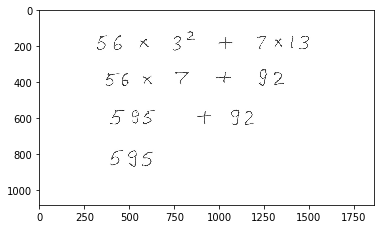

In [5]:
#Example equation using A,B,X,Y
eqn = 'A*X**2+B*Y'

#Variables value declaration
A = 56
B = 7
X = 3
Y = 13

img = cv2.imread('box.jpg',0)
plt.imshow(img, cmap='gray')

'2/4'

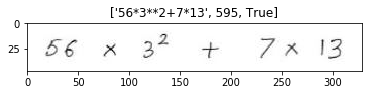

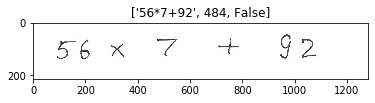

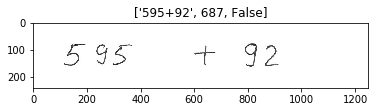

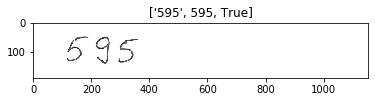

In [6]:
#Calling a folder
checker_iter('image',eqn,A,B,X,Y)